# Кибериммунная автономность$\\$Создание конструктивно защищённого автономного наземного транспортного средства$\\$Модуль 2

## О документе

Версия 1.03

Модуль 2 для регионального этапа соревнований по кибериммунной автономности

## Подготовка к работе c модулем 2

Перенесите в блок ниже ваши реализации классов коммуникационного шлюза (CommunicationGateway), систему навигации (NavigationSystem), управления (ControlSystem)

In [2]:
from multiprocessing import Queue
from src.communication_gateway import BaseCommunicationGateway
from src.config import CONTROL_SYSTEM_QUEUE_NAME
from src.event_types import Event
from src.config import SERVOS_QUEUE_NAME
from src.control_system import BaseControlSystem
from src.config import CONTROL_SYSTEM_QUEUE_NAME
from src.navigation_system import BaseNavigationSystem

class CommunicationGateway(BaseCommunicationGateway):
    """Класс для реализации логики взаимодействия с системой планирования заданий.
    Работает в отдельном процессе, поэтому создаётся как наследник класса Process.
    """
    def _send_mission_to_consumers(self):
        """Метод для отправки сообщения с маршрутным заданием в систему управления."""
        
        # Получаем имя очереди системы управления
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME

        # Создаём событие с маршрутным заданием
        event = Event(
            source=BaseCommunicationGateway.event_source_name,
            destination=control_q_name,
            operation="set_mission",
            parameters=self._mission
        )

        # Ищем в каталоге нужную очередь
        control_q: Queue = self._queues_dir.get_queue(control_q_name)

        # Отправляем событие в найденную очередь
        control_q.put(event)
        
class ControlSystem(BaseControlSystem):
    """ControlSystem блок расчёта управления """

    def _send_speed_and_direction_to_consumers(self, speed, direction):
        servos_q_name = SERVOS_QUEUE_NAME # замените на правильное название очереди
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)

        # отправка сообщения с желаемой скоростью
        event_speed = Event(
            source=BaseControlSystem.event_source_name,
            destination=servos_q_name,
            operation="set_speed",
            parameters=speed
        )                   # замените на код создания сообщения со скоростью для приводов
                            # подсказка, требуемая операция - set_speed

        # отправка сообщения с желаемым направлением
        event_direction = Event(
            source=BaseControlSystem.event_source_name,
            destination=servos_q_name,
            operation="set_direction",
            parameters=direction
        )                       # замените на код создания сообщения с направлением для приводов
                                # подсказка, требуемая операция - set_direction

        servos_q.put(event_speed)
        servos_q.put(event_direction)       

class NavigationSystem(BaseNavigationSystem):
    """ класс навигационного блока """
    def _send_position_to_consumers(self):                              
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME # замените на правильное название очереди
        event = Event(
            source=BaseNavigationSystem.event_source_name,
            destination=control_q_name,
            operation="position_update",
            parameters=self._position           # Координаты текущего местоположения
        )                                       # замените на код создания сообщения с координатами для системы управления 
                                                # подсказка, требуемая операция - position_update
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        control_q.put(event)



Если у вас настроена и работает СУПА, установите в True значение переменной afcs_present

In [29]:
afcs_present = True

В этом модуле изменим идентификатор машинки:

In [30]:
car_id = "m2" 

### Модуль 2. Отправка маршрутного здания и следование по маршруту

В рамках этого модуля отрабатывается только автономность. 
Никаких киберпрепятствий пока не будет. 

Что нужно сделать по пунктам:
1. Для заданных начальных и конечных точек создать маршрут, содержащий не менее пяти промежуточных путевых точек вручную или с использованием таких инструментов как APMPlanner, MissionPlanner. <br>Содержимое wpl файла нужно вставить в соответствующий кодовый блок блокнота, запустить симуляцию и убедиться, что машинка успешно проходит этот маршрут.
2. Задать скоростные ограничения в виде массива элементов GeoSpecificSpeedLimit
3. Запустить симуляцию


Формат WPL файла описан на этой странице: 

https://mavlink.io/en/file_formats/#mission_plain_text_file

Пример содержимого файла с текстовым описанием маршрута

In [ ]:
wpl_file_content_for_example =  """QGC WPL 110
0	1	0	16	0	5	0	0	59.9391061791295741	30.3156781196594238	0	1
1	0	3	16	0	5	0	0	59.938515001968419	30.312201976776123	0	1
2	0	3	16	0	5	0	0	59.9421371401196978	30.3066229820251465	0	1
3	0	3	16	0	5	0	0	59.9410946067827126	30.3039407730102539	0	1
4	0	3	16	0	5	0	0	59.9403744872963955	30.302116870880127	0	1
5	0	3	16	0	5	0	0	59.9412316426749499	30.3011056780815125	0	1
6	0	3	16	0	5	0	0	59.9411147591553188	30.3006818890571594	0	1
"""



Для выполнения задания в блоке ниже  
1. замените имя файла с маршрутом (на свой), вот эту строку:
   ```python
   wpl_file = "module2.wpl"
   ```
2. измените список скоростных ограничений, вот этот массив:
   ```python
   speed_limits = [
    GeoSpecificSpeedLimit(...
    ```
   
Учтите, что вам нужно доставить груз как можно быстрее, но при этом не нарушить правила дорожного движения. 

Ограничения скорости
- населённый пункт - 60 км/ч
- пешеходная зона - 20 км/ч
- магистраль - 110 км/ч

Составьте маршрут доставки так, чтобы машинка доехала за минимальное время. Для определения оптимального маршрута допустимо пользоваться сторонними сервисами (например, Яндекс картами).

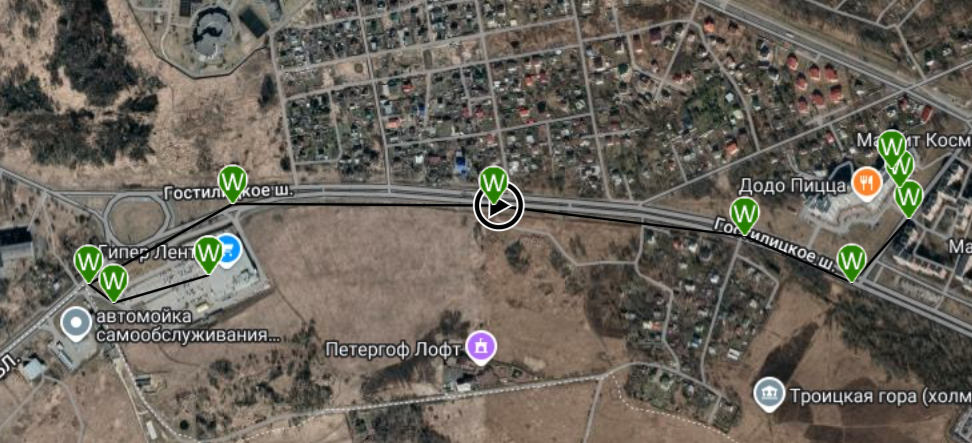

In [52]:
#Мой маршрут
wpl_file_content =  """QGC WPL 110
0	1	0	16	0	5	0	0	59.869328 29.827365	0	1
1	0	3	16	0	5	0	0	59.868883 29.824322	0	1
2	0	3	16	0	5	0	0	59.869184 29.823516	0	1
3	0	3	16	0	5	0	0	59.870481 29.828145	0	1
4	0	3	16	0	5	0	0	59.870456 29.836566 0	1
5	0	3	16	0	5	0	0	59.869963 29.844628 0	1
6	0	3	16	0	5	0	0	59.869206 29.848098	0	1
7	0	3	16	0	5	0	0	59.870235 29.849917	0	1
8	0	3	16	0	5	0	0	59.870743 29.849644	0	1
9	0	3	16	0	5	0	0	59.871044 29.849363	0	1
"""


In [53]:
# создадим wpl файл и запишем туда маршрутное задание
wpl_file = "module2.wpl"

**Примечание**:
После создания собственного маршрута удалите перезапись содержимого, чтобы не потерять свои наработки!


In [54]:
with open(wpl_file, "w") as f:
    f.write(wpl_file_content)

**Напоминание**: не забудьте изменить скоростные ограничения (speed_limits) при задании маршрутного задания!

In [ ]:
from src.wpl_parser import WPLParser

parser = WPLParser(wpl_file)    
points = parser.parse()
print(points)

from src.mission_type import GeoSpecificSpeedLimit
speed_limits = [
    GeoSpecificSpeedLimit(0, 20),
    GeoSpecificSpeedLimit(2, 60),
    GeoSpecificSpeedLimit(7, 20),
]

from src.mission_planner import Mission

home = points[0]
mission = Mission(home=home, waypoints=points,speed_limits=speed_limits, armed=True)

[Point(59.869328, 29.827365, 0.0), Point(59.868883, 29.824322, 0.0), Point(59.869184, 29.823516, 0.0), Point(59.870481, 29.828145, 0.0), Point(59.870456, 29.836566, 0.0), Point(59.869963, 29.844628, 0.0), Point(59.869206, 29.848098, 0.0), Point(59.870235, 29.849917, 0.0), Point(59.870743, 29.849644, 0.0), Point(59.871044, 29.849363, 0.0)]


Запускаем симуляцию с новым маршрутным заданием

In [56]:
from time import sleep
from geopy import Point as GeoPoint


from src.queues_dir import QueuesDirectory
from src.servos import Servos
from src.sitl import SITL
from src.cargo_bay import CargoBay
from src.mission_planner import MissionPlanner
from src.config import LOG_ERROR, LOG_INFO
from src.mission_planner_mqtt import MissionSender
from src.sitl_mqtt import TelemetrySender
from src.system_wrapper import SystemComponentsContainer


# координата текущего положения машинки
home = GeoPoint(latitude=59.869494, longitude=29.828101) 


# каталог очередей для передачи сообщений между блоками
queues_dir = QueuesDirectory() 

if afcs_present:
    mission_sender = MissionSender(
        queues_dir=queues_dir, client_id=car_id, log_level=LOG_ERROR)
    telemetry_sender = TelemetrySender(
        queues_dir=queues_dir, client_id=car_id, log_level=LOG_ERROR)

mission_planner = MissionPlanner(
    queues_dir, afcs_present=afcs_present, mission=mission)

sitl = SITL(
    queues_dir=queues_dir, position=home,
    car_id=car_id, post_telemetry=afcs_present, log_level=LOG_ERROR)


communication_gateway = CommunicationGateway(
    queues_dir=queues_dir, log_level=LOG_ERROR)
control_system = ControlSystem(queues_dir=queues_dir, log_level=LOG_INFO)

navigation_system = NavigationSystem(
    queues_dir=queues_dir, log_level=LOG_ERROR)

servos = Servos(queues_dir=queues_dir, log_level=LOG_ERROR)
cargo_bay = CargoBay(queues_dir=queues_dir, log_level=LOG_INFO)

# у нас получилось довольно много блоков, используем класс SystemComponentsContainer
# для упрощения рутинной работы с ними - таким образом мы собираем все блоки машинки в одном "кузове"
system_components = SystemComponentsContainer(
    components=[
        mission_sender,
        telemetry_sender,
        sitl,
        mission_planner,
        navigation_system,
        servos,
        cargo_bay,
        communication_gateway,
        control_system
    ] if afcs_present else [
        sitl,
        mission_planner,
        navigation_system,
        servos,
        cargo_bay,
        communication_gateway,
        control_system
    ])

system_components.start()

# ограничение поездки по времени
# параметр sleep - время в секундах,
# настройте этот параметр так, чтобы ваша машинка завершила маршрут
# в случае превышения времени выполнения ячейки на более чем 10 секунд от заданного, 
# допустимо перезапустить вычислительное ядро и повторно выполнить весь блокнот, штрафные очки за это не начисляются
# при условии, что повторный запуск закончился успешно
sleep(100)

# останавливаем все компоненты
system_components.stop()

# удалим все созданные компоненты
system_components.clean()

[ИНФО][QUEUES] создан каталог очередей
[ИНФО][QUEUES] регистрируем очередь planner.mqtt
[ИНФО][QUEUES] регистрируем очередь sitl.mqtt
[ИНФО][QUEUES] регистрируем очередь planner
[ИНФО][MISSION PLANNER] создана система планирования заданий
[ИНФО][QUEUES] регистрируем очередь sitl
[ИНФО][QUEUES] регистрируем очередь communication
[ИНФО][QUEUES] регистрируем очередь control
[ИНФО][CONTROL] создана система управления
[ИНФО][QUEUES] регистрируем очередь navigation
[ИНФО][QUEUES] регистрируем очередь servos
[ИНФО][QUEUES] регистрируем очередь cargo
[ИНФО][CARGO] создан компонент грузового отсека, отсек заблокирован
[ИНФО][MISSION PLANNER] старт системы планирования заданий
[ИНФО][CARGO] старт блока грузового отсека
[ИНФО][CONTROL] старт системы управления
[ИНФО][MISSION PLANNER] запрошена новая задача, отправляем получателям
[ИНФО][MISSION PLANNER] новая задача отправлена в коммуникационный шлюз
[ИНФО][CONTROL] установлена новая задача, начинаем следовать по маршруту, текущее время 16:19:44.

На этом модуль 2 завершён, надеемся, у вас всё получилось! 
На что можно ещё обратить вниманием - можно ли как-то улучшить маршрут для ускорения доставки? (без нарушения ПДД) - например, использовать более скоростные трассы или срезать какие-то участки.

Если идей быстрых улучшений нет, то пришло время перейти к самому интересному модулю и познакомиться с киберпрепятствиями!

Для работы над модулем 3 задания откройте блокнот cyberimmunity--autonomous-car-m3.